In [15]:
#!/usr/bin/env python3

import os
import sys
from datetime import date
from pathlib import Path
import shutil

# ── 1. SETTINGS ────────────────────────────────────────────────────────────
folder = Path(r"D:\DPA\new_base\test_images")  # <-- your folder here
today  = date.today().strftime("%d%m%y")        # e.g. 12-07-25 → "120725"
exts   = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"}

# ── 2. COLLECT FILES ───────────────────────────────────────────────────────
files = [p for p in folder.iterdir()
         if p.is_file() and p.suffix.lower() in exts]

if not files:
    sys.exit("No image files found.")

# deterministic ordering (alphabetical) before numbering
files.sort(key=lambda p: p.name.lower())

# ── 3. RENAME ONE BY ONE ───────────────────────────────────────────────────
for idx, old_path in enumerate(files, start=1):
    new_name = f"{today}{idx}{old_path.suffix.lower()}"
    new_path = folder / new_name

    # If a collision somehow happens, add an underscore until it's unique
    while new_path.exists():
        new_path = new_path.with_stem(new_path.stem + "_")

    # Copy → verify → delete old (safer than os.rename on Windows)
    shutil.copy2(old_path, new_path)
    new_size = new_path.stat().st_size
    if new_size == old_path.stat().st_size:     # crude integrity check
        old_path.unlink()                       # delete original
    else:
        new_path.unlink()                       # rollback
        print(f"⚠️  Skipped {old_path.name}: copy verification failed.")

print("✅  All done!")

✅  All done!


In [1]:
# Cell 1: Imports and Device Setup

import os 
import time
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Detect GPUs
if not torch.cuda.is_available():
    device = torch.device("cpu")
    print("CUDA not available — using CPU")
else:
    n_gpus = torch.cuda.device_count()
    device = torch.device("cuda:0")
    print(f"CUDA available: {n_gpus} GPU(s), using device {device}")

# Later on, wrap your model in DataParallel if n_gpus > 1

CUDA available: 1 GPU(s), using device cuda:0


In [2]:

# Cell 2: Color Map and Mask Conversion (Background = index 0)
COLOR_MAP = {
    (0, 0, 0): 0,             # Background → 0
    (255, 255, 0): 1,        # Crater → 1
    (255, 0, 0): 2,          # Rough → 2
    (0, 255, 0): 3,          # Smooth → 3
    (0, 0, 255): 4,          # Alluvial_Fan → 4
    (139, 69, 19): 5         # Boulders → 5
}

def mask_to_class(mask: Image.Image) -> np.ndarray:
    """
    Convert an RGB mask image to a 2D array of class indices.
    """
    mask = np.array(mask)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for rgb, idx in COLOR_MAP.items():
        class_mask[(mask == rgb).all(axis=-1)] = idx
    return class_mask 

In [4]:
# Cell 3: Dataset Definition
class MarsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted([f for f in os.listdir(image_dir) if f.startswith("img_")])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name.replace("img_", "mask_")

        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB").resize((256, 256))
        mask_img = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB")\
        .resize((256, 256), resample=Image.NEAREST)

        if self.transform:
            image = self.transform(image)

        mask = mask_to_class(mask_img)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

In [5]:
# Cell 4: Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Scales to [0,1]
])

train_dataset = MarsDataset(
    image_dir=r"D:\DPA\new_base\train_images",
    mask_dir=r"D:\DPA\new_base\train_masks",
    transform=transform
)
val_dataset = MarsDataset(
    image_dir=r"D:\DPA\new_base\val_image",
    mask_dir=r"D:\DPA\new_base\val_mask",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8,  shuffle=False  )


In [6]:
# Cell 5: CBAM Blocks and U-Net Definition
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv1(torch.cat([avg, max_], dim=1)))

class ConvBlockCBAM(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        self.ca = ChannelAttention(out_c)
        self.sa = SpatialAttention()
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlockCBAM(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        f = self.conv(x)
        p = self.pool(f)
        return f, p
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        self.conv = ConvBlockCBAM(out_c*2, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class CBAMUNet(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.enc1 = EncoderBlock(3,  64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128,256)
        self.enc4 = EncoderBlock(256,512)
        self.bottleneck = ConvBlockCBAM(512,1024)
        self.dec1 = DecoderBlock(1024,512)
        self.dec2 = DecoderBlock(512,256)
        self.dec3 = DecoderBlock(256,128)
        self.dec4 = DecoderBlock(128,64)
        self.final = nn.Conv2d(64, num_classes, 1)
    def forward(self, x):
        s1,p1 = self.enc1(x)
        s2,p2 = self.enc2(p1)
        s3,p3 = self.enc3(p2)
        s4,p4 = self.enc4(p3)
        b     = self.bottleneck(p4)
        d1    = self.dec1(b,   s4)
        d2    = self.dec2(d1,  s3)
        d3    = self.dec3(d2,  s2)
        d4    = self.dec4(d3,  s1)
        return self.final(d4)

In [7]:
num_epochs = 100
# Define class weights (higher weight for Alluvial_Fan)
class_weights = torch.tensor([0.0, 1.0, 1.0, 1.0, 2.5, 3.5])  # [background, Crater, Rough, Smooth, Alluvial_Fan, boulders]
class_weights = class_weights.to(device)  # Move to GPU if available

# Custom Combined Loss (CrossEntropy + Dice)
class CombinedLoss(nn.Module):
    def __init__(self, weights, smooth=1e-5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights, ignore_index=0)
        self.smooth = smooth

    def forward(self, pred, target):
        # CrossEntropyLoss
        ce_loss = self.ce(pred, target)
        # DiceLoss
        pred = pred.softmax(dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, pred.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = (pred + target_one_hot).sum(dim=(2, 3))
        dice_loss = 1 - (2 * intersection / (union + self.smooth)).mean()
        return ce_loss + dice_loss  # Combined loss

# Model, Loss, Optimizer, Scheduler
model = CBAMUNet(num_classes=6).to(device)
criterion = CombinedLoss(weights=class_weights)  # Combined loss with class weights [[8]]
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)  # AdamW for regularization [[9]]
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(train_loader)
)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision training [[10]]

In [8]:
# Training Loop with Mixed Precision
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision [[10]]
            outputs = model(imgs)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

# Metric helpers (unchanged)
def compute_confusion_elements(pred, true, class_id):
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = (pred_i & true_i).sum()
    fp = (pred_i & ~true_i).sum()
    fn = (~pred_i & true_i).sum()
    return tp, fp, fn

def eval_one_epoch(model, loader, criterion, device, class_ids):
    model.eval()
    total_loss = 0
    sum_tp = {c:0 for c in class_ids}
    sum_fp = {c:0 for c in class_ids}
    sum_fn = {c:0 for c in class_ids}
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            total_loss += criterion(logits, masks).item()
            preds = torch.argmax(logits, dim=1)
            for c in class_ids:
                tp, fp, fn = compute_confusion_elements(preds, masks, c)
                sum_tp[c] += tp
                sum_fp[c] += fp
                sum_fn[c] += fn
    loss = total_loss / len(loader)
    ious = {c: sum_tp[c] / (sum_tp[c] + sum_fp[c] + sum_fn[c] + 1e-8) for c in class_ids}
    return loss, ious

In [10]:
# Cell 8: Training Loop with Per-Class IoU Logging (using mean IoU to save best model)
num_epochs = 100
best_val_iou = 0.0  # Track best mean IoU across all classes

# Evaluate all five foreground classes (1–5)
eval_classes = [1, 2, 3, 4, 5]
class_names = {
    1: 'Crater',
    2: 'Rough',
    3: 'Smooth',
    4: 'Alluvial_Fan',
    5: 'Boulders'
}

for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation step
    val_loss, val_ious = eval_one_epoch(model, val_loader, criterion, device, eval_classes)
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    for c in eval_classes:
        print(f"    {class_names[c]:15s} IoU: {val_ious[c]:.4f}")

    # Compute mean IoU over all eval_classes
    mean_iou = sum(val_ious[c] for c in eval_classes) / len(eval_classes)
    print(f"  Mean IoU: {mean_iou:.4f}")

    # Save best model based on mean IoU
    # if mean_iou > best_val_iou:
    #     best_val_iou = mean_iou
    #     torch.save(model.state_dict(), r"C:\u net\new base\best_moon and mars_segmentation_model.pth")
    #     print("✅ Saved new best model (mean IoU improved)\n")
    # else:
    #     print()


Epoch 1/100
  Train Loss: 2.0228
  Val   Loss: 1.8176
    Crater          IoU: 0.1993
    Rough           IoU: 0.5413
    Smooth          IoU: 0.5704
    Alluvial_Fan    IoU: 0.1423
    Boulders        IoU: 0.0000
  Mean IoU: 0.2907


Epoch 2/100
  Train Loss: 1.7221
  Val   Loss: 1.5566
    Crater          IoU: 0.2648
    Rough           IoU: 0.5581
    Smooth          IoU: 0.5942
    Alluvial_Fan    IoU: 0.1474
    Boulders        IoU: 0.0000
  Mean IoU: 0.3129


Epoch 3/100
  Train Loss: 1.4624
  Val   Loss: 1.3761
    Crater          IoU: 0.3013
    Rough           IoU: 0.5725
    Smooth          IoU: 0.6164
    Alluvial_Fan    IoU: 0.1521
    Boulders        IoU: 0.0000
  Mean IoU: 0.3285


Epoch 4/100
  Train Loss: 1.3086
  Val   Loss: 1.2429
    Crater          IoU: 0.3430
    Rough           IoU: 0.6156
    Smooth          IoU: 0.6429
    Alluvial_Fan    IoU: 0.1505
    Boulders        IoU: 0.0000
  Mean IoU: 0.3504


Epoch 5/100
  Train Loss: 1.2387
  Val   Loss: 1.1851
    Crater          IoU: 0.3340
    Rough           IoU: 0.6350
    Smooth          IoU: 0.6788
    Alluvial_Fan    IoU: 0.1428
    Boulders        IoU: 0.0000
  Mean IoU: 0.3581


Epoch 6/100
  Train Loss: 1.1649
  Val   Loss: 1.1216
    Crater          IoU: 0.3221
    Rough           IoU: 0.5985
    Smooth          IoU: 0.7243
    Alluvial_Fan    IoU: 0.1444
    Boulders        IoU: 0.0000
  Mean IoU: 0.3579


Epoch 7/100
  Train Loss: 1.1021
  Val   Loss: 1.0609
    Crater          IoU: 0.2947
    Rough           IoU: 0.6277
    Smooth          IoU: 0.7665
    Alluvial_Fan    IoU: 0.1409
    Boulders        IoU: 0.0000
  Mean IoU: 0.3660


Epoch 8/100
  Train Loss: 1.0749
  Val   Loss: 1.0522
    Crater          IoU: 0.3090
    Rough           IoU: 0.6696
    Smooth          IoU: 0.7776
    Alluvial_Fan    IoU: 0.2233
    Boulders        IoU: 0.0000
  Mean IoU: 0.3959


Epoch 9/100
  Train Loss: 1.0239
  Val   Loss: 1.0082
    Crater          IoU: 0.4579
    Rough           IoU: 0.6962
    Smooth          IoU: 0.7810
    Alluvial_Fan    IoU: 0.2493
    Boulders        IoU: 0.0000
  Mean IoU: 0.4369


Epoch 10/100
  Train Loss: 0.9965
  Val   Loss: 0.9747
    Crater          IoU: 0.5565
    Rough           IoU: 0.6750
    Smooth          IoU: 0.8258
    Alluvial_Fan    IoU: 0.2132
    Boulders        IoU: 0.0000
  Mean IoU: 0.4541


Epoch 11/100
  Train Loss: 0.9682
  Val   Loss: 0.9615
    Crater          IoU: 0.5841
    Rough           IoU: 0.6812
    Smooth          IoU: 0.8053
    Alluvial_Fan    IoU: 0.2957
    Boulders        IoU: 0.0000
  Mean IoU: 0.4732


Epoch 12/100
  Train Loss: 0.9369
  Val   Loss: 0.9248
    Crater          IoU: 0.6102
    Rough           IoU: 0.7270
    Smooth          IoU: 0.8227
    Alluvial_Fan    IoU: 0.2925
    Boulders        IoU: 0.0000
  Mean IoU: 0.4905


Epoch 13/100
  Train Loss: 0.9040
  Val   Loss: 0.8920
    Crater          IoU: 0.6612
    Rough           IoU: 0.7084
    Smooth          IoU: 0.8533
    Alluvial_Fan    IoU: 0.3051
    Boulders        IoU: 0.0000
  Mean IoU: 0.5056


Epoch 14/100
  Train Loss: 0.8820
  Val   Loss: 0.8696
    Crater          IoU: 0.7128
    Rough           IoU: 0.7252
    Smooth          IoU: 0.8568
    Alluvial_Fan    IoU: 0.3180
    Boulders        IoU: 0.0000
  Mean IoU: 0.5225


Epoch 15/100
  Train Loss: 0.8522
  Val   Loss: 0.8899
    Crater          IoU: 0.6962
    Rough           IoU: 0.7158
    Smooth          IoU: 0.7881
    Alluvial_Fan    IoU: 0.3598
    Boulders        IoU: 0.0000
  Mean IoU: 0.5120


Epoch 16/100
  Train Loss: 0.8456
  Val   Loss: 0.8397
    Crater          IoU: 0.7064
    Rough           IoU: 0.7461
    Smooth          IoU: 0.8723
    Alluvial_Fan    IoU: 0.4193
    Boulders        IoU: 0.0000
  Mean IoU: 0.5488


Epoch 17/100
  Train Loss: 0.8125
  Val   Loss: 0.8293
    Crater          IoU: 0.6987
    Rough           IoU: 0.7197
    Smooth          IoU: 0.8705
    Alluvial_Fan    IoU: 0.3760
    Boulders        IoU: 0.0000
  Mean IoU: 0.5330


Epoch 18/100
  Train Loss: 0.7940
  Val   Loss: 0.8860
    Crater          IoU: 0.6680
    Rough           IoU: 0.7338
    Smooth          IoU: 0.8563
    Alluvial_Fan    IoU: 0.4694
    Boulders        IoU: 0.0000
  Mean IoU: 0.5455


Epoch 19/100
  Train Loss: 0.8102
  Val   Loss: 0.8063
    Crater          IoU: 0.7647
    Rough           IoU: 0.7558
    Smooth          IoU: 0.8732
    Alluvial_Fan    IoU: 0.4064
    Boulders        IoU: 0.0000
  Mean IoU: 0.5600


Epoch 20/100
  Train Loss: 0.7702
  Val   Loss: 0.8157
    Crater          IoU: 0.6226
    Rough           IoU: 0.7538
    Smooth          IoU: 0.8521
    Alluvial_Fan    IoU: 0.4148
    Boulders        IoU: 0.0000
  Mean IoU: 0.5287


Epoch 21/100
  Train Loss: 0.7747
  Val   Loss: 0.7859
    Crater          IoU: 0.7760
    Rough           IoU: 0.7602
    Smooth          IoU: 0.8792
    Alluvial_Fan    IoU: 0.4091
    Boulders        IoU: 0.0000
  Mean IoU: 0.5649


Epoch 22/100
  Train Loss: 0.7376
  Val   Loss: 0.7661
    Crater          IoU: 0.7922
    Rough           IoU: 0.7773
    Smooth          IoU: 0.8777
    Alluvial_Fan    IoU: 0.4533
    Boulders        IoU: 0.0000
  Mean IoU: 0.5801


Epoch 23/100
  Train Loss: 0.7188
  Val   Loss: 0.7499
    Crater          IoU: 0.7541
    Rough           IoU: 0.7839
    Smooth          IoU: 0.8959
    Alluvial_Fan    IoU: 0.4228
    Boulders        IoU: 0.0000
  Mean IoU: 0.5713


Epoch 24/100
  Train Loss: 0.7045
  Val   Loss: 0.7498
    Crater          IoU: 0.7505
    Rough           IoU: 0.7821
    Smooth          IoU: 0.8922
    Alluvial_Fan    IoU: 0.4608
    Boulders        IoU: 0.0000
  Mean IoU: 0.5771


Epoch 25/100
  Train Loss: 0.6908
  Val   Loss: 0.7431
    Crater          IoU: 0.7821
    Rough           IoU: 0.7876
    Smooth          IoU: 0.8824
    Alluvial_Fan    IoU: 0.4821
    Boulders        IoU: 0.0000
  Mean IoU: 0.5868


Epoch 26/100
  Train Loss: 0.6790
  Val   Loss: 0.7432
    Crater          IoU: 0.8249
    Rough           IoU: 0.7884
    Smooth          IoU: 0.8840
    Alluvial_Fan    IoU: 0.5033
    Boulders        IoU: 0.0000
  Mean IoU: 0.6001


Epoch 27/100
  Train Loss: 0.6790
  Val   Loss: 0.7481
    Crater          IoU: 0.8075
    Rough           IoU: 0.7797
    Smooth          IoU: 0.8746
    Alluvial_Fan    IoU: 0.4790
    Boulders        IoU: 0.0000
  Mean IoU: 0.5882


Epoch 28/100
  Train Loss: 0.6835
  Val   Loss: 0.7410
    Crater          IoU: 0.8124
    Rough           IoU: 0.7964
    Smooth          IoU: 0.8945
    Alluvial_Fan    IoU: 0.5002
    Boulders        IoU: 0.0000
  Mean IoU: 0.6007


Epoch 29/100
  Train Loss: 0.6558
  Val   Loss: 0.7160
    Crater          IoU: 0.7856
    Rough           IoU: 0.7969
    Smooth          IoU: 0.8992
    Alluvial_Fan    IoU: 0.4932
    Boulders        IoU: 0.0000
  Mean IoU: 0.5950


Epoch 30/100
  Train Loss: 0.6692
  Val   Loss: 0.7319
    Crater          IoU: 0.8126
    Rough           IoU: 0.8041
    Smooth          IoU: 0.8930
    Alluvial_Fan    IoU: 0.4682
    Boulders        IoU: 0.0000
  Mean IoU: 0.5956


Epoch 31/100
  Train Loss: 0.6682
  Val   Loss: 0.7366
    Crater          IoU: 0.7791
    Rough           IoU: 0.7929
    Smooth          IoU: 0.8917
    Alluvial_Fan    IoU: 0.4964
    Boulders        IoU: 0.0000
  Mean IoU: 0.5920


Epoch 32/100
  Train Loss: 0.6421
  Val   Loss: 0.6925
    Crater          IoU: 0.8353
    Rough           IoU: 0.8129
    Smooth          IoU: 0.9116
    Alluvial_Fan    IoU: 0.5694
    Boulders        IoU: 0.0000
  Mean IoU: 0.6259


Epoch 33/100
  Train Loss: 0.6184
  Val   Loss: 0.6918
    Crater          IoU: 0.8416
    Rough           IoU: 0.8243
    Smooth          IoU: 0.9122
    Alluvial_Fan    IoU: 0.5456
    Boulders        IoU: 0.0000
  Mean IoU: 0.6247


Epoch 34/100
  Train Loss: 0.6074
  Val   Loss: 0.7009
    Crater          IoU: 0.8484
    Rough           IoU: 0.8299
    Smooth          IoU: 0.9098
    Alluvial_Fan    IoU: 0.5953
    Boulders        IoU: 0.0000
  Mean IoU: 0.6367


Epoch 35/100
  Train Loss: 0.6055
  Val   Loss: 0.6939
    Crater          IoU: 0.8522
    Rough           IoU: 0.8246
    Smooth          IoU: 0.9125
    Alluvial_Fan    IoU: 0.5776
    Boulders        IoU: 0.0000
  Mean IoU: 0.6334


Epoch 36/100
  Train Loss: 0.6350
  Val   Loss: 0.6902
    Crater          IoU: 0.8446
    Rough           IoU: 0.8247
    Smooth          IoU: 0.9175
    Alluvial_Fan    IoU: 0.6015
    Boulders        IoU: 0.0000
  Mean IoU: 0.6377


Epoch 37/100
  Train Loss: 0.5987
  Val   Loss: 0.6862
    Crater          IoU: 0.8492
    Rough           IoU: 0.8277
    Smooth          IoU: 0.9140
    Alluvial_Fan    IoU: 0.6067
    Boulders        IoU: 0.0000
  Mean IoU: 0.6395


Epoch 38/100
  Train Loss: 0.5910
  Val   Loss: 0.6977
    Crater          IoU: 0.8530
    Rough           IoU: 0.8349
    Smooth          IoU: 0.9194
    Alluvial_Fan    IoU: 0.6206
    Boulders        IoU: 0.0000
  Mean IoU: 0.6456


Epoch 39/100
  Train Loss: 0.5863
  Val   Loss: 0.6916
    Crater          IoU: 0.8546
    Rough           IoU: 0.8281
    Smooth          IoU: 0.9203
    Alluvial_Fan    IoU: 0.6244
    Boulders        IoU: 0.0000
  Mean IoU: 0.6455


Epoch 40/100
  Train Loss: 0.5824
  Val   Loss: 0.6909
    Crater          IoU: 0.8516
    Rough           IoU: 0.8354
    Smooth          IoU: 0.9220
    Alluvial_Fan    IoU: 0.6201
    Boulders        IoU: 0.0000
  Mean IoU: 0.6458


Epoch 41/100
  Train Loss: 0.5771
  Val   Loss: 0.6884
    Crater          IoU: 0.8529
    Rough           IoU: 0.8417
    Smooth          IoU: 0.9232
    Alluvial_Fan    IoU: 0.6490
    Boulders        IoU: 0.0000
  Mean IoU: 0.6533


Epoch 42/100
  Train Loss: 0.5764
  Val   Loss: 0.6716
    Crater          IoU: 0.8615
    Rough           IoU: 0.8412
    Smooth          IoU: 0.9242
    Alluvial_Fan    IoU: 0.6238
    Boulders        IoU: 0.0000
  Mean IoU: 0.6501


Epoch 43/100
  Train Loss: 0.5714
  Val   Loss: 0.6859
    Crater          IoU: 0.8633
    Rough           IoU: 0.8442
    Smooth          IoU: 0.9204
    Alluvial_Fan    IoU: 0.6499
    Boulders        IoU: 0.0000
  Mean IoU: 0.6556


Epoch 44/100
  Train Loss: 0.5652
  Val   Loss: 0.6928
    Crater          IoU: 0.8450
    Rough           IoU: 0.8361
    Smooth          IoU: 0.9226
    Alluvial_Fan    IoU: 0.6365
    Boulders        IoU: 0.0000
  Mean IoU: 0.6481


Epoch 45/100
  Train Loss: 0.5695
  Val   Loss: 0.6932
    Crater          IoU: 0.8637
    Rough           IoU: 0.8405
    Smooth          IoU: 0.9218
    Alluvial_Fan    IoU: 0.6303
    Boulders        IoU: 0.0000
  Mean IoU: 0.6512


Epoch 46/100
  Train Loss: 0.5674
  Val   Loss: 0.6918
    Crater          IoU: 0.8640
    Rough           IoU: 0.8418
    Smooth          IoU: 0.9131
    Alluvial_Fan    IoU: 0.6436
    Boulders        IoU: 0.0000
  Mean IoU: 0.6525


Epoch 47/100
  Train Loss: 0.6039
  Val   Loss: 0.7045
    Crater          IoU: 0.8625
    Rough           IoU: 0.8342
    Smooth          IoU: 0.9077
    Alluvial_Fan    IoU: 0.6268
    Boulders        IoU: 0.0000
  Mean IoU: 0.6462


Epoch 48/100
  Train Loss: 0.5641
  Val   Loss: 0.6696
    Crater          IoU: 0.8655
    Rough           IoU: 0.8460
    Smooth          IoU: 0.9261
    Alluvial_Fan    IoU: 0.6614
    Boulders        IoU: 0.0000
  Mean IoU: 0.6598


Epoch 49/100
  Train Loss: 0.5511
  Val   Loss: 0.6818
    Crater          IoU: 0.8655
    Rough           IoU: 0.8434
    Smooth          IoU: 0.9234
    Alluvial_Fan    IoU: 0.6752
    Boulders        IoU: 0.0000
  Mean IoU: 0.6615


Epoch 50/100
  Train Loss: 0.5467
  Val   Loss: 0.6731
    Crater          IoU: 0.8654
    Rough           IoU: 0.8441
    Smooth          IoU: 0.9291
    Alluvial_Fan    IoU: 0.6799
    Boulders        IoU: 0.0000
  Mean IoU: 0.6637


Epoch 51/100
  Train Loss: 0.5486
  Val   Loss: 0.6630
    Crater          IoU: 0.8669
    Rough           IoU: 0.8488
    Smooth          IoU: 0.9264
    Alluvial_Fan    IoU: 0.6563
    Boulders        IoU: 0.0000
  Mean IoU: 0.6597


Epoch 52/100
  Train Loss: 0.5424
  Val   Loss: 0.6829
    Crater          IoU: 0.8679
    Rough           IoU: 0.8491
    Smooth          IoU: 0.9283
    Alluvial_Fan    IoU: 0.6899
    Boulders        IoU: 0.0000
  Mean IoU: 0.6670


Epoch 53/100
  Train Loss: 0.5400
  Val   Loss: 0.6654
    Crater          IoU: 0.8615
    Rough           IoU: 0.8508
    Smooth          IoU: 0.9311
    Alluvial_Fan    IoU: 0.6878
    Boulders        IoU: 0.0000
  Mean IoU: 0.6662


Epoch 54/100
  Train Loss: 0.5367
  Val   Loss: 0.6950
    Crater          IoU: 0.8672
    Rough           IoU: 0.8495
    Smooth          IoU: 0.9157
    Alluvial_Fan    IoU: 0.7024
    Boulders        IoU: 0.0000
  Mean IoU: 0.6670


Epoch 55/100
  Train Loss: 0.5393
  Val   Loss: 0.6774
    Crater          IoU: 0.8757
    Rough           IoU: 0.8522
    Smooth          IoU: 0.9248
    Alluvial_Fan    IoU: 0.6692
    Boulders        IoU: 0.0000
  Mean IoU: 0.6644


Epoch 56/100
  Train Loss: 0.5356
  Val   Loss: 0.6779
    Crater          IoU: 0.8715
    Rough           IoU: 0.8548
    Smooth          IoU: 0.9285
    Alluvial_Fan    IoU: 0.7063
    Boulders        IoU: 0.0000
  Mean IoU: 0.6722


Epoch 57/100
  Train Loss: 0.5327
  Val   Loss: 0.6753
    Crater          IoU: 0.8669
    Rough           IoU: 0.8519
    Smooth          IoU: 0.9255
    Alluvial_Fan    IoU: 0.6831
    Boulders        IoU: 0.0000
  Mean IoU: 0.6655


Epoch 58/100
  Train Loss: 0.5315
  Val   Loss: 0.6775
    Crater          IoU: 0.8761
    Rough           IoU: 0.8531
    Smooth          IoU: 0.9301
    Alluvial_Fan    IoU: 0.6979
    Boulders        IoU: 0.0000
  Mean IoU: 0.6714


Epoch 59/100
  Train Loss: 0.5288
  Val   Loss: 0.6680
    Crater          IoU: 0.8793
    Rough           IoU: 0.8567
    Smooth          IoU: 0.9324
    Alluvial_Fan    IoU: 0.7112
    Boulders        IoU: 0.0000
  Mean IoU: 0.6759


Epoch 60/100
  Train Loss: 0.5272
  Val   Loss: 0.6866
    Crater          IoU: 0.8729
    Rough           IoU: 0.8524
    Smooth          IoU: 0.9306
    Alluvial_Fan    IoU: 0.6990
    Boulders        IoU: 0.0000
  Mean IoU: 0.6710


Epoch 61/100
  Train Loss: 0.5257
  Val   Loss: 0.6695
    Crater          IoU: 0.8615
    Rough           IoU: 0.8528
    Smooth          IoU: 0.9314
    Alluvial_Fan    IoU: 0.6821
    Boulders        IoU: 0.0000
  Mean IoU: 0.6655


Epoch 62/100
  Train Loss: 0.5277
  Val   Loss: 0.6789
    Crater          IoU: 0.8760
    Rough           IoU: 0.8512
    Smooth          IoU: 0.9296
    Alluvial_Fan    IoU: 0.6996
    Boulders        IoU: 0.0000
  Mean IoU: 0.6713


Epoch 63/100
  Train Loss: 0.6430
  Val   Loss: 0.7714
    Crater          IoU: 0.7007
    Rough           IoU: 0.7821
    Smooth          IoU: 0.8648
    Alluvial_Fan    IoU: 0.5351
    Boulders        IoU: 0.0000
  Mean IoU: 0.5765


Epoch 64/100
  Train Loss: 0.5757
  Val   Loss: 0.6612
    Crater          IoU: 0.8723
    Rough           IoU: 0.8515
    Smooth          IoU: 0.9285
    Alluvial_Fan    IoU: 0.6841
    Boulders        IoU: 0.0000
  Mean IoU: 0.6673


Epoch 65/100
  Train Loss: 0.5309
  Val   Loss: 0.6719
    Crater          IoU: 0.8791
    Rough           IoU: 0.8582
    Smooth          IoU: 0.9319
    Alluvial_Fan    IoU: 0.7165
    Boulders        IoU: 0.0000
  Mean IoU: 0.6772


Epoch 66/100
  Train Loss: 0.5219
  Val   Loss: 0.6711
    Crater          IoU: 0.8776
    Rough           IoU: 0.8618
    Smooth          IoU: 0.9333
    Alluvial_Fan    IoU: 0.7203
    Boulders        IoU: 0.0000
  Mean IoU: 0.6786


Epoch 67/100
  Train Loss: 0.5173
  Val   Loss: 0.6627
    Crater          IoU: 0.8802
    Rough           IoU: 0.8583
    Smooth          IoU: 0.9348
    Alluvial_Fan    IoU: 0.7177
    Boulders        IoU: 0.0000
  Mean IoU: 0.6782


Epoch 68/100
  Train Loss: 0.5136
  Val   Loss: 0.6722
    Crater          IoU: 0.8812
    Rough           IoU: 0.8609
    Smooth          IoU: 0.9337
    Alluvial_Fan    IoU: 0.7271
    Boulders        IoU: 0.0000
  Mean IoU: 0.6806


Epoch 69/100
  Train Loss: 0.5133
  Val   Loss: 0.6916
    Crater          IoU: 0.8767
    Rough           IoU: 0.8588
    Smooth          IoU: 0.9356
    Alluvial_Fan    IoU: 0.7363
    Boulders        IoU: 0.0000
  Mean IoU: 0.6815


Epoch 70/100
  Train Loss: 0.5144
  Val   Loss: 0.6674
    Crater          IoU: 0.8756
    Rough           IoU: 0.8593
    Smooth          IoU: 0.9332
    Alluvial_Fan    IoU: 0.7148
    Boulders        IoU: 0.0000
  Mean IoU: 0.6766


Epoch 71/100
  Train Loss: 0.5121
  Val   Loss: 0.6653
    Crater          IoU: 0.8799
    Rough           IoU: 0.8631
    Smooth          IoU: 0.9356
    Alluvial_Fan    IoU: 0.7145
    Boulders        IoU: 0.0000
  Mean IoU: 0.6786


Epoch 72/100
  Train Loss: 0.5114
  Val   Loss: 0.6749
    Crater          IoU: 0.8773
    Rough           IoU: 0.8642
    Smooth          IoU: 0.9355
    Alluvial_Fan    IoU: 0.7230
    Boulders        IoU: 0.0000
  Mean IoU: 0.6800


Epoch 73/100
  Train Loss: 0.5098
  Val   Loss: 0.6754
    Crater          IoU: 0.8810
    Rough           IoU: 0.8625
    Smooth          IoU: 0.9328
    Alluvial_Fan    IoU: 0.7330
    Boulders        IoU: 0.0000
  Mean IoU: 0.6819


Epoch 74/100
  Train Loss: 0.5626
  Val   Loss: 0.6690
    Crater          IoU: 0.8676
    Rough           IoU: 0.8509
    Smooth          IoU: 0.9270
    Alluvial_Fan    IoU: 0.6777
    Boulders        IoU: 0.0000
  Mean IoU: 0.6646


Epoch 75/100
  Train Loss: 0.5220
  Val   Loss: 0.6632
    Crater          IoU: 0.8834
    Rough           IoU: 0.8639
    Smooth          IoU: 0.9322
    Alluvial_Fan    IoU: 0.7258
    Boulders        IoU: 0.0000
  Mean IoU: 0.6811


Epoch 76/100
  Train Loss: 0.5104
  Val   Loss: 0.6702
    Crater          IoU: 0.8826
    Rough           IoU: 0.8642
    Smooth          IoU: 0.9368
    Alluvial_Fan    IoU: 0.7325
    Boulders        IoU: 0.0000
  Mean IoU: 0.6832


Epoch 77/100
  Train Loss: 0.5073
  Val   Loss: 0.6713
    Crater          IoU: 0.8787
    Rough           IoU: 0.8636
    Smooth          IoU: 0.9369
    Alluvial_Fan    IoU: 0.7389
    Boulders        IoU: 0.0000
  Mean IoU: 0.6836


Epoch 78/100
  Train Loss: 0.5062
  Val   Loss: 0.6709
    Crater          IoU: 0.8864
    Rough           IoU: 0.8645
    Smooth          IoU: 0.9361
    Alluvial_Fan    IoU: 0.7350
    Boulders        IoU: 0.0000
  Mean IoU: 0.6844


Epoch 79/100
  Train Loss: 0.5057
  Val   Loss: 0.6783
    Crater          IoU: 0.8893
    Rough           IoU: 0.8646
    Smooth          IoU: 0.9360
    Alluvial_Fan    IoU: 0.7373
    Boulders        IoU: 0.0000
  Mean IoU: 0.6854


Epoch 80/100
  Train Loss: 0.5059
  Val   Loss: 0.6759
    Crater          IoU: 0.8724
    Rough           IoU: 0.8646
    Smooth          IoU: 0.9339
    Alluvial_Fan    IoU: 0.7308
    Boulders        IoU: 0.0000
  Mean IoU: 0.6803


Epoch 81/100
  Train Loss: 0.5051
  Val   Loss: 0.6764
    Crater          IoU: 0.8834
    Rough           IoU: 0.8604
    Smooth          IoU: 0.9367
    Alluvial_Fan    IoU: 0.7370
    Boulders        IoU: 0.0000
  Mean IoU: 0.6835


Epoch 82/100
  Train Loss: 0.5060
  Val   Loss: 0.6842
    Crater          IoU: 0.8860
    Rough           IoU: 0.8640
    Smooth          IoU: 0.9370
    Alluvial_Fan    IoU: 0.7429
    Boulders        IoU: 0.0000
  Mean IoU: 0.6860


Epoch 83/100
  Train Loss: 0.5041
  Val   Loss: 0.6906
    Crater          IoU: 0.8851
    Rough           IoU: 0.8629
    Smooth          IoU: 0.9359
    Alluvial_Fan    IoU: 0.7432
    Boulders        IoU: 0.0000
  Mean IoU: 0.6854


Epoch 84/100
  Train Loss: 0.5055
  Val   Loss: 0.6695
    Crater          IoU: 0.8763
    Rough           IoU: 0.8609
    Smooth          IoU: 0.9337
    Alluvial_Fan    IoU: 0.7341
    Boulders        IoU: 0.0000
  Mean IoU: 0.6810


Epoch 85/100
  Train Loss: 0.5035
  Val   Loss: 0.6774
    Crater          IoU: 0.8852
    Rough           IoU: 0.8650
    Smooth          IoU: 0.9355
    Alluvial_Fan    IoU: 0.7436
    Boulders        IoU: 0.0000
  Mean IoU: 0.6859


Epoch 86/100
  Train Loss: 0.5038
  Val   Loss: 0.6918
    Crater          IoU: 0.8868
    Rough           IoU: 0.8652
    Smooth          IoU: 0.9332
    Alluvial_Fan    IoU: 0.7426
    Boulders        IoU: 0.0000
  Mean IoU: 0.6856


Epoch 87/100
  Train Loss: 0.5092
  Val   Loss: 0.6824
    Crater          IoU: 0.8762
    Rough           IoU: 0.8621
    Smooth          IoU: 0.9290
    Alluvial_Fan    IoU: 0.7301
    Boulders        IoU: 0.0000
  Mean IoU: 0.6795


Epoch 88/100
  Train Loss: 0.5045
  Val   Loss: 0.6762
    Crater          IoU: 0.8786
    Rough           IoU: 0.8642
    Smooth          IoU: 0.9331
    Alluvial_Fan    IoU: 0.7323
    Boulders        IoU: 0.0000
  Mean IoU: 0.6816


Epoch 89/100
  Train Loss: 0.5005
  Val   Loss: 0.6786
    Crater          IoU: 0.8883
    Rough           IoU: 0.8693
    Smooth          IoU: 0.9363
    Alluvial_Fan    IoU: 0.7457
    Boulders        IoU: 0.0000
  Mean IoU: 0.6879


Epoch 90/100
  Train Loss: 0.4999
  Val   Loss: 0.6694
    Crater          IoU: 0.8807
    Rough           IoU: 0.8663
    Smooth          IoU: 0.9368
    Alluvial_Fan    IoU: 0.7377
    Boulders        IoU: 0.0000
  Mean IoU: 0.6843


Epoch 91/100
  Train Loss: 0.4983
  Val   Loss: 0.6773
    Crater          IoU: 0.8863
    Rough           IoU: 0.8672
    Smooth          IoU: 0.9379
    Alluvial_Fan    IoU: 0.7427
    Boulders        IoU: 0.0000
  Mean IoU: 0.6868


Epoch 92/100
  Train Loss: 0.4977
  Val   Loss: 0.6885
    Crater          IoU: 0.8840
    Rough           IoU: 0.8701
    Smooth          IoU: 0.9391
    Alluvial_Fan    IoU: 0.7467
    Boulders        IoU: 0.0000
  Mean IoU: 0.6880


Epoch 93/100
  Train Loss: 0.5003
  Val   Loss: 0.6860
    Crater          IoU: 0.8817
    Rough           IoU: 0.8619
    Smooth          IoU: 0.9314
    Alluvial_Fan    IoU: 0.7384
    Boulders        IoU: 0.0000
  Mean IoU: 0.6827


Epoch 94/100
  Train Loss: 0.4987
  Val   Loss: 0.6843
    Crater          IoU: 0.8873
    Rough           IoU: 0.8680
    Smooth          IoU: 0.9388
    Alluvial_Fan    IoU: 0.7470
    Boulders        IoU: 0.0000
  Mean IoU: 0.6882


Epoch 95/100
  Train Loss: 0.4993
  Val   Loss: 0.6723
    Crater          IoU: 0.8794
    Rough           IoU: 0.8685
    Smooth          IoU: 0.9361
    Alluvial_Fan    IoU: 0.7440
    Boulders        IoU: 0.0000
  Mean IoU: 0.6856


Epoch 96/100
  Train Loss: 0.5043
  Val   Loss: 0.6918
    Crater          IoU: 0.8669
    Rough           IoU: 0.8576
    Smooth          IoU: 0.9322
    Alluvial_Fan    IoU: 0.7104
    Boulders        IoU: 0.0000
  Mean IoU: 0.6734


Epoch 97/100
  Train Loss: 0.6333
  Val   Loss: 0.7003
    Crater          IoU: 0.8280
    Rough           IoU: 0.8397
    Smooth          IoU: 0.9110
    Alluvial_Fan    IoU: 0.6685
    Boulders        IoU: 0.0000
  Mean IoU: 0.6495


Epoch 98/100
  Train Loss: 0.5283
  Val   Loss: 0.6649
    Crater          IoU: 0.8823
    Rough           IoU: 0.8609
    Smooth          IoU: 0.9343
    Alluvial_Fan    IoU: 0.7276
    Boulders        IoU: 0.0000
  Mean IoU: 0.6810


Epoch 99/100
  Train Loss: 0.5038
  Val   Loss: 0.6644
    Crater          IoU: 0.8854
    Rough           IoU: 0.8646
    Smooth          IoU: 0.9356
    Alluvial_Fan    IoU: 0.7411
    Boulders        IoU: 0.0000
  Mean IoU: 0.6853


Epoch 100/100
  Train Loss: 0.4954
  Val   Loss: 0.6665
    Crater          IoU: 0.8899
    Rough           IoU: 0.8697
    Smooth          IoU: 0.9384
    Alluvial_Fan    IoU: 0.7502
    Boulders        IoU: 0.0000
  Mean IoU: 0.6896


In [ ]:
# Cell 9: Full Validation Metrics (IoU, Dice, Precision, Recall, Loss, Inference Time)

import time
import numpy as np
import torch

# --- 1. Metric definitions ---
def compute_confusion_elements(pred, true, class_id):
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = np.logical_and(pred_i, true_i).sum()
    fp = np.logical_and(pred_i, ~true_i).sum()
    fn = np.logical_and(~pred_i, true_i).sum()
    return tp, fp, fn

def compute_iou(tp, fp, fn):
    return tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

def compute_dice(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

def compute_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def compute_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# --- 2. Evaluation loop ---
def evaluate_model(model, dataloader, criterion, num_classes=6, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_time = 0.0
    total_samples = 0

    # accumulators per class (0 = background, 1–5 = foreground)
    sum_tp = np.zeros(num_classes, dtype=np.int64)
    sum_fp = np.zeros(num_classes, dtype=np.int64)
    sum_fn = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # time the forward pass
            torch.cuda.synchronize() if device != 'cpu' else None
            t0 = time.time()
            logits = model(imgs)
            torch.cuda.synchronize() if device != 'cpu' else None
            t1 = time.time()

            batch_size = imgs.size(0)
            total_time += (t1 - t0) * batch_size
            total_samples += batch_size

            # accumulate loss
            loss = criterion(logits, masks)
            total_loss += loss.item() * batch_size

            # predictions & truths to numpy
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            trues = masks.cpu().numpy()

            # accumulate confusion matrix elements for each class (0–5)
            for c in range(num_classes):
                for p, t in zip(preds, trues):
                    tp, fp, fn = compute_confusion_elements(p, t, c)
                    sum_tp[c] += tp
                    sum_fp[c] += fp
                    sum_fn[c] += fn

    # compute per-class metrics
    ious = [compute_iou(sum_tp[c], sum_fp[c], sum_fn[c]) for c in range(num_classes)]
    dices = [compute_dice(sum_tp[c], sum_fp[c], sum_fn[c]) for c in range(num_classes)]
    precs = [compute_precision(sum_tp[c], sum_fp[c]) for c in range(num_classes)]
    recs  = [compute_recall(sum_tp[c], sum_fn[c]) for c in range(num_classes)]

    return {
        'IoU_per_class': ious,
        'Mean_IoU': np.mean(ious),
        'Dice_per_class': dices,
        'Mean_Dice': np.mean(dices),
        'Precision_per_class': precs,
        'Mean_Precision': np.mean(precs),
        'Recall_per_class': recs,
        'Mean_Recall': np.mean(recs),
        'Avg_Loss': total_loss / total_samples,
        'Avg_Inference_Time_per_Image': total_time / total_samples
    }

# --- 3. Load best model (optional) ---
best_model = CBAMUNet(num_classes=6).to(device)
best_model.load_state_dict(torch.load(r"D:\u net\best_mars_segmentation_model.pth"))
best_model.eval()

# --- 4. Run evaluation ---
metrics = evaluate_model(best_model, val_loader, criterion, num_classes=6, device=device)

# --- 5. Display results ---
print("\n=== Validation Metrics ===")
for cls_id, name in class_names.items():  # class_names contains keys 1–5
    print(
        f"{name:15s} | IoU: {metrics['IoU_per_class'][cls_id]:.4f} "
        f"| Dice: {metrics['Dice_per_class'][cls_id]:.4f} "
        f"| Precision: {metrics['Precision_per_class'][cls_id]:.4f} "
        f"| Recall: {metrics['Recall_per_class'][cls_id]:.4f}"
    )
print(f"\nMean IoU (all 6 classes):       {metrics['Mean_IoU']:.4f}")
print(f"Mean Dice (all 6 classes):      {metrics['Mean_Dice']:.4f}")
print(f"Mean Precision (all 6 classes): {metrics['Mean_Precision']:.4f}")
print(f"Mean Recall (all 6 classes):    {metrics['Mean_Recall']:.4f}")
print(f"Avg Loss:       {metrics['Avg_Loss']:.4f}")
print(f"Avg Inference Time per Image: {metrics['Avg_Inference_Time_per_Image']*1000:.2f} ms")

C:\Users\HP\AppData\Local\Temp\ipykernel_24428\2906752188.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(r"D:\u net\best_mars_seg

RuntimeError: Error(s) in loading state_dict for CBAMUNet:
	size mismatch for final.weight: copying a param with shape torch.Size([5, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 64, 1, 1]).
	size mismatch for final.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([6]).

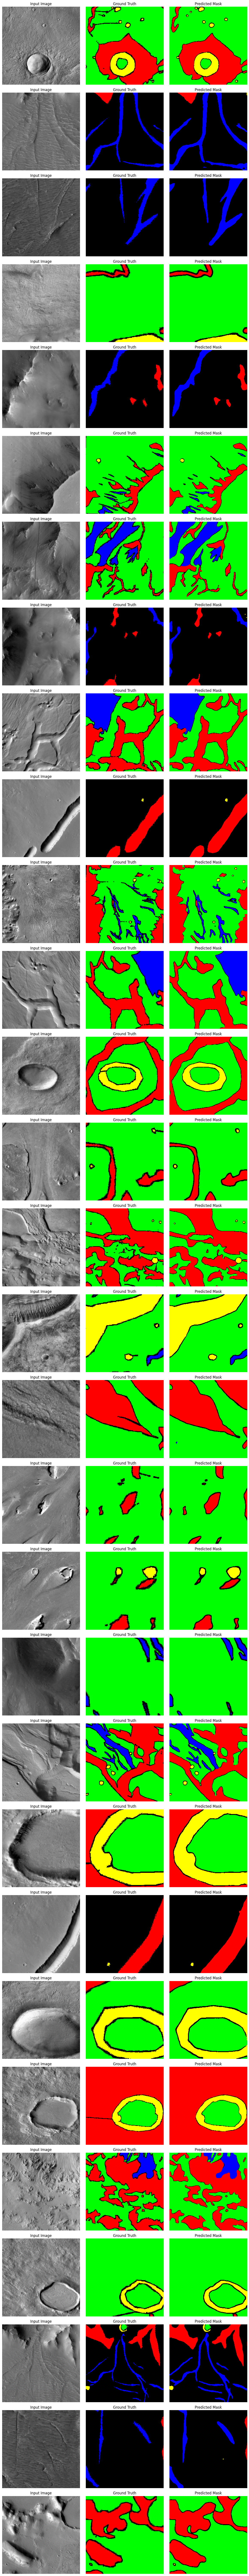

In [11]:
# Cell 10: Visualize Input | Ground Truth | Predicted Mask (6 total classes: background + 5 foreground)

import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure model is in eval mode
model.eval()

# Rebuild inverse mapping from class index → RGB color
INV_COLOR_MAP = {v: k for k, v in COLOR_MAP.items()}

def class_to_rgb(mask):
    """
    mask: 2D numpy array of class indices (0–5)
    returns: H×W×3 RGB image (uint8) according to INV_COLOR_MAP
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in INV_COLOR_MAP.items():
        rgb[mask == cls_idx] = color
    return rgb

def visualize_random_samples(dataset, model, device, n_samples=10):
    """
    Picks n_samples random items from dataset, runs model, and plots:
      [Input Image | Ground Truth RGB | Predicted RGB]
    """
    indices = random.sample(range(len(dataset)), n_samples)
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4 * n_samples))
    
    for row, idx in enumerate(indices):
        # Load image tensor & ground-truth mask
        img_tensor, gt_mask = dataset[idx]
        # Convert tensor to H×W×3 float image in [0,1]
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        # Convert gt_mask (torch.LongTensor) to 2D numpy of ints
        gt_mask_np = gt_mask.cpu().numpy()
        
        # Run model inference
        with torch.no_grad():
            inp = img_tensor.unsqueeze(0).to(device)    # Add batch dim
            logits = model(inp)
            pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
        
        # Convert both GT and prediction to RGB images
        gt_rgb   = class_to_rgb(gt_mask_np)
        pred_rgb = class_to_rgb(pred_mask)
        
        # Plot Input Image
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title("Input Image")
        axes[row, 0].axis('off')
        
        # Plot Ground-Truth Mask in color
        axes[row, 1].imshow(gt_rgb)
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis('off')
        
        # Plot Predicted Mask in color
        axes[row, 2].imshow(pred_rgb)
        axes[row, 2].set_title("Predicted Mask")
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example: visualize 10 random samples from the training set
visualize_random_samples(train_dataset, model, device, n_samples=30)


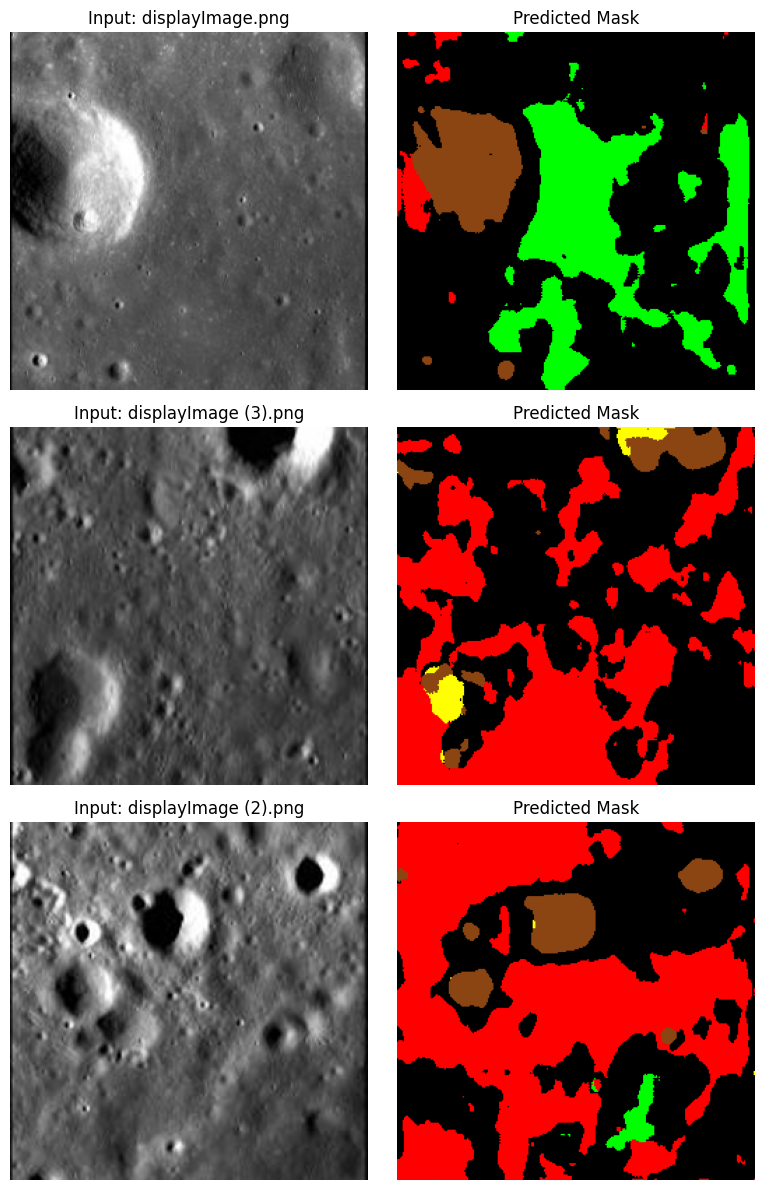

In [ ]:
# Cell 11: Visualize Test Images | Predicted Mask (6 total classes: background + 5 foreground)

import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# --- 1. Setup ---
test_image_dir = r"D:\DPA\new_base\test_images" # adjust to your test folder
file_names = [f for f in os.listdir(test_image_dir) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Reuse inverse color map from updated COLOR_MAP (should include classes 0–5)
INV_COLOR_MAP = {v: k for k, v in COLOR_MAP.items()}

def class_to_rgb(mask):
    """
    mask: 2D numpy array of class indices (0–5)
    returns: H×W×3 RGB image
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in INV_COLOR_MAP.items():
        rgb[mask == cls_idx] = color
    return rgb

# Image transform (must match training resizing + ToTensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# --- 2. Visualization function ---
def visualize_test_predictions(model, device, n_samples=4):
    model.eval()
    samples = random.sample(file_names, n_samples)
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4 * n_samples))
    for i, fname in enumerate(samples):
        # Load and preprocess image
        path = os.path.join(test_image_dir, fname)
        img_pil = Image.open(path).convert("RGB")
        img_resized = img_pil.resize((256, 256))
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        
        # Forward pass
        with torch.no_grad():
            logits = model(img_tensor)
            pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
        
        # Convert to displayable arrays
        img_np = np.array(img_resized)
        pred_rgb = class_to_rgb(pred_mask)
        
        # Plot input image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Input: {fname}")
        axes[i, 0].axis('off')
        
        # Plot predicted mask
        axes[i, 1].imshow(pred_rgb)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 3. Run it ---
visualize_test_predictions(model, device, n_samples=3)


# Dynamic 

In [ ]:
import os
import random
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm   # optional: nice progress bar

# --- 1. Setup ----------------------------------------------------------
test_image_dir = r"D:\DPA\new_base\test_images"     # source images
save_dir       = r"D:\DPA\new_base\train_masks"     # destination for masks
os.makedirs(save_dir, exist_ok=True)

file_names = [
    f for f in os.listdir(test_image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Inverse colour‑map: {class‑index → RGB tuple}
INV_COLOR_MAP = {v: k for k, v in COLOR_MAP.items()}

def class_to_rgb(mask: np.ndarray) -> np.ndarray:
    """Convert a 2‑D class‑index mask to an RGB image."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in INV_COLOR_MAP.items():
        rgb[mask == cls_idx] = color
    return rgb

# Must match training preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# --- 2. Predict + save -------------------------------------------------
def save_predicted_masks(model, device):
    model.eval()
    with torch.no_grad():
        for fname in tqdm(file_names, desc="Predicting masks"):
            img_path = os.path.join(test_image_dir, fname)
            img_pil  = Image.open(img_path).convert("RGB")
            img_tensor = transform(img_pil).unsqueeze(0).to(device)

            logits = model(img_tensor)
            pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Convert to RGB & save (same filename as input)
            pred_rgb = class_to_rgb(pred_mask)
            Image.fromarray(pred_rgb)\
                 .save(os.path.join(save_dir, fname))

    print(f"✅ Saved {len(file_names)} masks to: {save_dir}")

# --- 3. Run it ---------------------------------------------------------
save_predicted_masks(model, device)

Predicting masks: 100%|██████████| 116/116 [00:05<00:00, 23.13it/s]

✅ Saved 116 masks to: D:\DPA\new_base\train_masks


In [ ]:
# Cell 11: Visualize Test Images | Predict + Save Masks
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# --- 1. Setup ----------------------------------------------------------
test_image_dir = r"D:\DPA\new_base\test_images"   # <— source images
save_dir       = r"D:\DPA\new_base\train_masks"        # <— destination for masks
os.makedirs(save_dir, exist_ok=True)              # create if missing

file_names = [
    f for f in os.listdir(test_image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Inverse colour-map: {class-index 🡒 RGB tuple}
INV_COLOR_MAP = {v: k for k, v in COLOR_MAP.items()}

def class_to_rgb(mask: np.ndarray) -> np.ndarray:
    """
    Convert a 2-D class-index mask (values 0-5) to an RGB image.
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in INV_COLOR_MAP.items():
        rgb[mask == cls_idx] = color
    return rgb

# Must match training preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# --- 2. Predict, save, and visualise ----------------------------------
def visualize_and_save_predictions(model, device, n_samples: int = 4):
    model.eval()
    samples = random.sample(file_names, n_samples)

    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4 * n_samples))

    for i, fname in enumerate(samples):
        # -------- forward pass --------
        img_path = os.path.join(test_image_dir, fname)
        img_pil  = Image.open(img_path).convert("RGB")
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

        # -------- convert + save --------
        pred_rgb = class_to_rgb(pred_mask)               # H×W×3 uint8
        pred_img = Image.fromarray(pred_rgb)
        pred_img.save(os.path.join(save_dir, fname))     # same filename ✔

        # -------- plot (optional) --------
        axes[i, 0].imshow(img_pil.resize((256, 256)))
        axes[i, 0].set_title(f"Input: {fname}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_rgb)
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved {n_samples} masks to: {save_dir}")

# --- 3. Run it ---------------------------------------------------------
visualize_and_save_predictions(model, device, n_samples=3)


In [ ]:
import os
import shutil

path1 = r"D:\DPA\new_base\test_images"          # source folder
path2 = r"D:\DPA\new_base\train_images"          # destination folder
os.makedirs(path2, exist_ok=True)

# Copy images
for fname in os.listdir(path1):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(path1, fname)
        dst = os.path.join(path2, fname)
        shutil.copy2(src, dst)          # keeps timestamps/metadata
print("Copy complete!")